In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Black-Scholes 股票价格模型
* 我们假设股票收益率服从如下的关系
$$
\frac{S_{t+\Delta}-S_t}{S_t} = \mu\Delta + \sigma \sqrt{\Delta}  Z_{t+\Delta},\,\,\, Z_{t+\Delta} \sim N(0,1)
$$
* 其中股票的单位收益率在每一个交易区间都相同，我们用 $\mu$ 来表示
* 股票单位收益率的波动率在每一个交易区间也相同，我们用 $\sigma$ 来表示
* 银行存款的单位收益率我们用常数 $r$ 来表示
$$
\frac{D_{t+\Delta}-D_t}{D_t} = r\Delta
$$
* 在我们的例子里，$\Delta = 0.25/100$

In [2]:
N = 100 # 模型的期数
S0 = 1 # 资产初始价格
W0 = 1 # 初始货币资金
T = 0.25 # 投资周期，表示一个季度

σ = 0.2 # 波动率
μ = 0.08
r = .02

N_sample = 10**5 # 样本数量

Δ = T/N

基本性质 (当 $\Delta$ 比较小时)：
* 股票价格
$$
\frac{S_T}{S_0} \approx e^{(\mu-\frac{1}{2}\sigma^2) T + \sigma Z_T}
$$
* 对数收益率的期望
$$
\text{E}\left[\log \frac{S_T}{S_0}\right] \approx \mu - \frac{1}{2}\sigma^2 T
$$
* 对数收益率的方差
$$
\text{Var}\left[\log \frac{S_T}{S_0}\right] \approx \sigma^2 T
$$
* 简单收益率的期望
$$
\text{E}\left[\frac{S_T - S_0}{S_0}\right] \approx e^{\mu T} - 1
$$
* 简单收益率的方差
$$
\text{Var}\left[\frac{S_T - S_0}{S_0}\right] \approx e^{2\mu T + \sigma^2T } - e^{2\mu T}
$$

In [33]:
np.random.seed(1)
array_Z = np.random.normal(0, 1, size=(N_sample,N))

In [34]:
array_Z.shape

(100000, 100)

In [35]:
path_S = np.ones((N_sample, N+1))

for i in range(N):
    noise_S = np.sqrt(Δ)*σ*array_Z[:,i]
    increment_S = μ*Δ + noise_S
    path_S[:,i+1] = path_S[:,i]+path_S[:,i]*increment_S

Text(0, 0.5, '$S_t$')

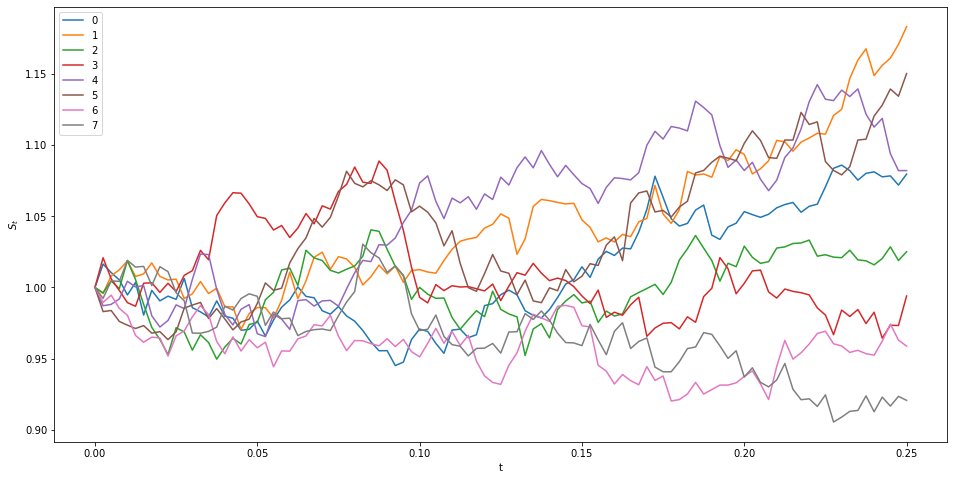

In [78]:
plt.figure(figsize=(16,8))
for i in range(8):
    plt.plot(np.linspace(0, T, N+1), path_S[i,:])
plt.legend(range(8))
plt.xlabel("t")
plt.ylabel("$S_t$")

* 我们用蒙特卡洛 (Monte Carlo) 方法来估计股票的简单收益率和对数收益率

In [68]:
df = pd.DataFrame({"simple_return": path_S[:,-1]/path_S[:,0]-1,
                   "log_return": np.log(path_S[:,-1]/path_S[:,0])})

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

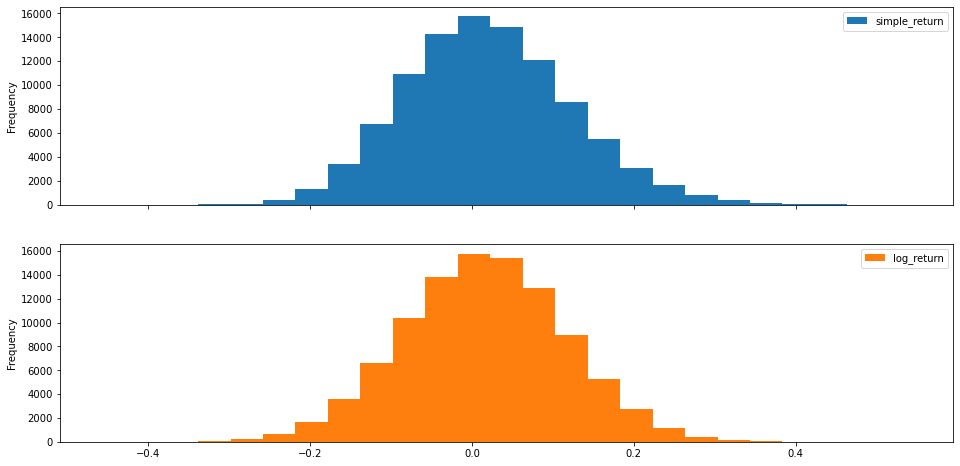

In [71]:
df.plot(kind='hist', subplots=True, bins=25, figsize=(16,8))

In [72]:
df.describe()

,simple_return,log_return
count,100000.000000,100000.000000
mean,0.020067,0.014916
std,0.101712,0.099556
min,-0.367972,-0.458822
25%,-0.050753,-0.052086
50%,0.015553,0.015433
75%,0.085538,0.082075
max,0.544328,0.434589


In [73]:
df.skew()

simple_return    0.282053
log_return      -0.019075
dtype: float64

In [74]:
df.kurt()

simple_return    0.146324
log_return       0.010728
dtype: float64

### 投资策略
* 我们用 $\pi_t$ 来表示每一时刻 $t$，用来投资股票的资金占当时本金的比重，那么假如 $t$ 期时，我们的财富总量为 $W_t$，那按照 $\pi_t$ 来投资会使得我们在 $t+\Delta$ 时刻的财富 $W_{t+\Delta}$ 满足
$$
W_{t+\Delta} = W_t(1 + r\Delta) + W_t\pi_t \left(\frac{S_{t+\Delta}-S_t}{S_t} - r\Delta\right)
$$

#### 例子
* 假如对于所有的时刻 $\pi_t \equiv 0$，那我们 $T$ 时刻的财富为
$$
W_T = W_0 (1+r\Delta)^{T/\Delta}
$$
* 假如对于所有的时刻 $\pi_t \equiv 1$，那我们 $T$ 时刻的财富为
$$
W_T = S_T
$$
* 更进一步的，我们也可以取 $\pi_t \equiv c$，其中 $c \in [0,2]$
* 或者 $\pi_t = 2$ 当 $S_{t} - S_{t-\Delta}>0$ 时，其它时间 $\pi_t = 0.6$
* 提问：你更喜欢哪一个资产配置投资策略？我们来计算一下不同 $\pi_t$ 时的 $W_T$

In [112]:
strategy = dict()

In [113]:
π = 0
WT = np.ones((N_sample,1))

for i in range(N):
    WT = WT*(1+r*Δ) + WT*π*((path_S[:,i+1]-path_S[:,i])/path_S[:,i]-r*Δ).reshape(N_sample,1)
strategy["π=0"] = np.squeeze(WT)

In [114]:
π = 0.5
WT = np.ones((N_sample,1))

for i in range(N):
    WT = WT*(1+r*Δ) + WT*π*((path_S[:,i+1]-path_S[:,i])/path_S[:,i]-r*Δ).reshape(N_sample,1)
strategy["π=0.5"] = np.squeeze(WT)

In [115]:
π = 1
WT = np.ones((N_sample,1))

for i in range(N):
    WT = WT*(1+r*Δ) + WT*π*((path_S[:,i+1]-path_S[:,i])/path_S[:,i]-r*Δ).reshape(N_sample,1)
strategy["π=1"] = np.squeeze(WT)

In [116]:
path_π = np.ones((N_sample, N))
WT = np.ones((N_sample,1))

for i in range(N):
    path_π[:,i] = 0.6
    if i>0:
        sample_positive = path_S[:,i]-path_S[:,i-1]>0
        path_π[sample_positive, i] = 2
        
    WT = WT*(1+r*Δ) + WT*(path_π[:,i]*((path_S[:,i+1]-path_S[:,i])/path_S[:,i]-r*Δ)).reshape(N_sample,1)
strategy["π dynamic"] = np.squeeze(WT)

Text(0, 0.5, '$\\pi_t$')

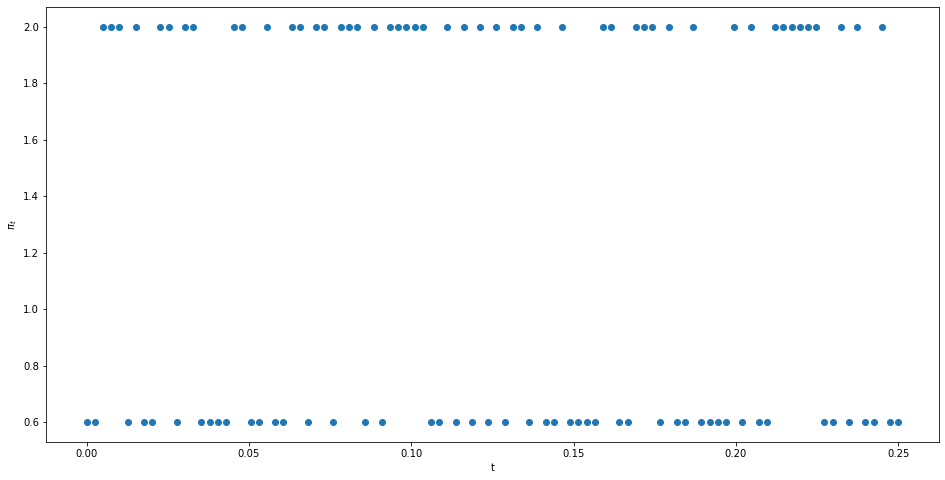

In [117]:
plt.figure(figsize=(16,8))
plt.plot(np.linspace(0, T, N), path_π[4,:], 'o')
plt.xlabel("t")
plt.ylabel("$\pi_t$")

In [136]:
df = pd.DataFrame(strategy)

In [137]:
df.describe()

,π=0,π=0.5,π=1,π dynamic,π star
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.005012e+00,1.012523,1.020067,1.024423,1.027641
std,1.401553e-12,0.050410,0.101712,0.154108,0.154104
min,1.005012e+00,0.798126,0.632028,0.554292,0.499056
25%,1.005012e+00,0.977942,0.949247,0.915715,0.919041
50%,1.005012e+00,1.011541,1.015553,1.008905,1.017074
75%,1.005012e+00,1.045791,1.085538,1.116599,1.124000
max,1.005012e+00,1.247760,1.544328,2.053549,1.905509


In [146]:
np.log(df).skew()

π=0          0.000000
π=0.5       -0.017563
π=1         -0.019075
π dynamic    0.160621
π star      -0.020588
dtype: float64

In [147]:
np.log(df).kurt()

π=0          0.000000
π=0.5        0.010521
π=1          0.010728
π dynamic    0.057024
π star       0.010945
dtype: float64

In [138]:
df.columns

Index(['π=0', 'π=0.5', 'π=1', 'π dynamic', 'π star'], dtype='object')

In [139]:
strategy_list = ['π=0.5', 'π=1', 'π dynamic']

In [140]:
(df[strategy_list].mean()-df['π=0'].mean())/df[strategy_list].std()

π=0.5        0.148999
π=1          0.148012
π dynamic    0.125957
dtype: float64

### 如何评估资产配置策略的优劣？
* 提问：直接选择财富最大化可行吗？
* 财富带来的效用最大化（决策理论 decision theory）
    * 例子：优化目标 
    $$
    \sum_t \text{E}\left[\frac{W_{t+\Delta}-W_t}{W_t}\right] - \frac{\gamma}{2}\text{Var}\left[\frac{W_{t+\Delta}-W_t}{W_t}\right],
    $$
    * 最优策略 $\pi_t = \frac{\mu_t - r}{\sigma_t}\frac{1}{\gamma \sigma_t}$
* 财富平均复利增长率最快（投机行为中常用的标准）
    * 例子：优化目标 
    $$
    \frac{1}{T} \text{E} \left[\log \frac{W_T}{W_0} \right],
    $$
    * 最优策略 $\pi_t = \frac{\mu_t - r}{\sigma_t}\frac{1}{\sigma_t}$ 

In [133]:
γ = 1

In [134]:
π = (μ-r)/(γ*σ**2)
print(π)

1.4999999999999996


In [135]:
WT = np.ones((N_sample,1))

for i in range(N):
    WT = WT*(1+r*Δ) + WT*π*((path_S[:,i+1]-path_S[:,i])/path_S[:,i]-r*Δ).reshape(N_sample,1)
strategy["π star"] = np.squeeze(WT)

In [143]:
np.log(df).mean()/T

π=0          0.020000
π=0.5        0.044829
π=1          0.059663
π dynamic    0.052483
π star       0.064500
dtype: float64

### 均值回归 (mean-reverting) 随机收益率模型 
* 我们假设风险资产的收益率不再是常数，也称为 Ornstein-Uhlenbeck 随机过程
$$
\mu_{t+\Delta} - \mu_t = \kappa (\bar \mu - \mu_t) \Delta + \sigma_\mu \sqrt{\Delta} \left(\rho Z_{t+\Delta}+ \sqrt{1-\rho^2} B_{t+\Delta}\right)
$$
    * 其中我们仍取 $\bar \mu = 0.08$，作为风险资产短期收益率的长期均值
    * 我们取 $\kappa = 0.5$，它反映了收益率向均值回归的速度
    * 我们取 $\sigma_\mu = 0.1$，它反映了方差向均值回归时受到的干扰
    * 我们取初始的 $\mu_0=0.06$
    * 我们取 $\rho = 0.2$，它反映了当股票短期收益率受到正向的扰动时，股票下一期的短期收益率会受到一部分正向的扰动
    * $B_{t+\Delta} \sim N(0,1)$，且与其它干扰项相互独立

In [9]:
np.random.seed(1)
array_Z = np.random.normal(0, 1, size=(N_sample,N))
array_B = np.random.normal(0, 1, size=(N_sample,N))

In [10]:
barμ = 0.08
κ = 0.5
σμ = 0.1
μ0 = 0.06
ρ = 0.2

In [11]:
path_S = np.ones((N_sample, N+1))
path_μ = np.ones((N_sample, N+1))*μ0

for i in range(N):
    noise_S = σ*np.sqrt(Δ)*array_Z[:,i]
    noise_μ = σμ*np.sqrt(Δ)*(ρ*array_Z[:,i] + np.sqrt(1-ρ**2)*array_B[:,i])
    
    increment_S = path_μ[:,i]*Δ + noise_S
    increment_μ = κ*(barμ - path_μ[:,i])*Δ + noise_μ
    
    path_S[:,i+1] = path_S[:,i] + path_S[:,i]*increment_S
    path_μ[:,i+1] = path_μ[:,i] + increment_μ

Text(0, 0.5, '$S_t$')

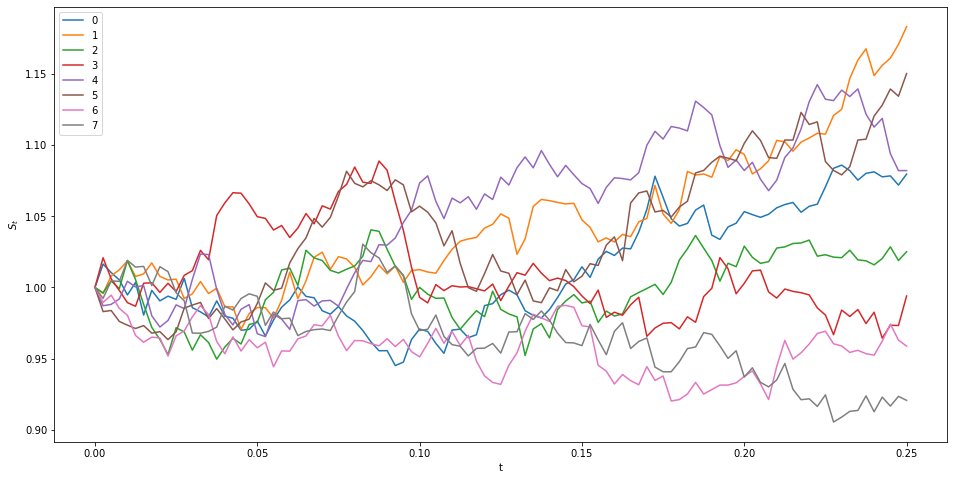

In [84]:
plt.figure(figsize=(16,8))
for i in range(8):
    plt.plot(np.linspace(0, T, N+1), path_S[i,:])
plt.legend(range(8))
plt.xlabel("t")
plt.ylabel("$S_t$")

Text(0, 0.5, '$\\mu_t$')

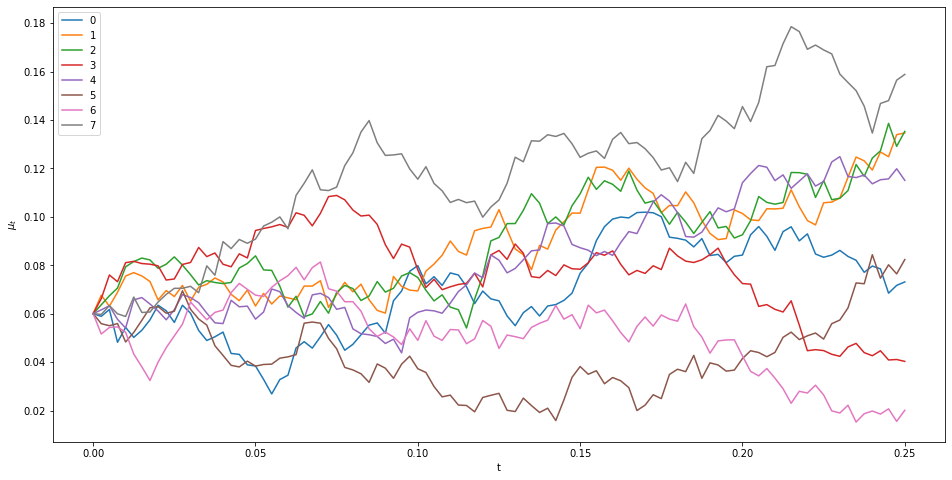

In [80]:
plt.figure(figsize=(16,8))
for i in range(8):
    plt.plot(np.linspace(0, T, N+1), path_μ[i,:])
plt.legend(range(8))
plt.xlabel("t")
plt.ylabel("$\mu_t$")

In [14]:
γ = 2

In [15]:
path_π = np.ones((N_sample, N))
WT = np.ones((N_sample,1))

for i in range(N):
    path_π[:,i] = (path_μ[:,i]-r)/σ/(γ*σ)
    WT = WT*(1+r*Δ) + WT*(path_π[:,i]*((path_S[:,i+1]-path_S[:,i])/path_S[:,i]-r*Δ)).reshape(N_sample,1)

Text(0, 0.5, '$\\pi_t$')

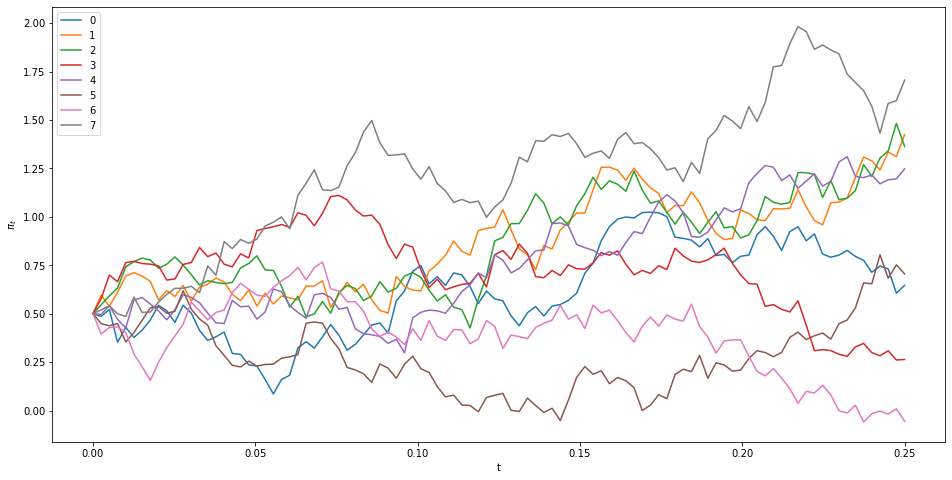

In [82]:
plt.figure(figsize=(16,8))
for i in range(8):
    plt.plot(np.linspace(0, T, N), path_π[i,:])
plt.legend(range(8))
plt.xlabel("t")
plt.ylabel("$\pi_t$")

In [17]:
np.mean(np.log(WT/W0))

0.011671434231524981

(array([2.0000e+00, 1.1000e+01, 1.5000e+01, 4.5000e+01, 1.6900e+02,
        5.2500e+02, 1.5830e+03, 4.7620e+03, 1.3788e+04, 2.9528e+04,
        2.5826e+04, 1.2628e+04, 5.8410e+03, 2.7380e+03, 1.3310e+03,
        6.2800e+02, 2.8700e+02, 1.6100e+02, 5.6000e+01, 4.9000e+01,
        1.6000e+01, 6.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-0.3986721 , -0.35816975, -0.31766739, -0.27716504, -0.23666269,
        -0.19616034, -0.15565799, -0.11515564, -0.07465329, -0.03415094,
         0.00635141,  0.04685376,  0.08735612,  0.12785847,  0.16836082,
         0.20886317,  0.24936552,  0.28986787,  0.33037022,  0.37087257,
         0.41137492,  0.45187727,  0.49237963,  0.53288198,  0.57338433,
         0.61388668]),
 <BarContainer object of 25 artists>)

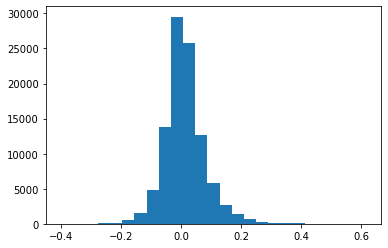

In [18]:
plt.hist(np.log(WT/W0), bins=25)

### 考虑交易成本？